### faceID

FaceID meaning one can register his/her face by taking few pictures of him and later use the FaceID to identify the person.

One of the most discussed features of the new iPhone X is the new unlocking method, FaceID. Apple has revolutionized the way we unlock a phone: by simply looking at it. It uses front facing depth-camera for that. iPhone X in able to create a 3D map of the face of the user with that. In addition, a picture of the user’s face is captured using an infrared camera, that is more robust to changes in light and color of the environment. Using deep learning, the smartphone is able to learn the user face in great detail, thus recognizing him\her every time the phone is picked up by its owner. 

Lets understand how it is different from the conventional face recognition system.
Performing classification, for a neural network, means learning to predict if the face it has seen it’s the users’s one or not. So, it should use some training data to predict “true” or “false”. 
Here this approach would not work because it requires the network to be re-trained from scratch using the new obtained data from the user’s face. This would require a lot of time, energy consumption, and impractical availability of training data of different faces to have negative examples (little would change in case of transfer learning and fine tuning of an already trained network). 

Instead, FaceID is probably powered by a siamese-like convolutional neural network that is trained “offline” by Apple to map faces into a low-dimensional latent space shaped to maximize distances between faces of different people, using a contrastive loss. What happens is that you get an architecture capable of doing one shot learning.

##### Siamese Network
A siamese neural network is basically composed by two identical neural networks that also share all the weights. This architecture can learn to compute distances between particular kind of data, such as images. The idea is that you pass couples of data through the siamese networks (or simply pass the data in two different steps through the same network), the network maps it in a low dimensional feature space, like a n-dimensional array, and then you train the network to make this mapping so that data points from different classes are as far as possible, while data points from the same class are as close as possible. In the long run, the network will learn to extract the most meaningful features from data, and compress it into an array, creating an meaningful mapping. A siamese neural network can learn to do this for you, similarly to what an autoencoder does.



# Let's Start by Loading the dataset

iPhone X in able to create a 3D map of the face of the user using the front facing depth-camera. In addition, a picture of the user’s face is captured using an infrared camera, that is more robust to changes in light and color of the environment.

For simplicity I have used only RGB images for the exercise.

In [ ]:
!rm -r faceid_train
!rm -r faceid_val

In [ ]:
!ls

In [ ]:
!mkdir faceid_train
!mkdir faceid_val

In [ ]:
link_list=["http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(151751).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(153054).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(154211).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(160440).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(160931).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(161342).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(163349).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-16)(164248).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-17)(141550).zip", \
          "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-17)(142154).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-17)(142457).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-17)(143016).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(132824).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(133201).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(133846).zip", \
          "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(134239).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(134757).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(140516).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(143345).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(144316).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(145150).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(145623).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(150303).zip", \
          "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(150650).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(151337).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(151650).zip"]
val_list=["http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(152717).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(153532).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(154129).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(154728).zip", "http://vap.aau.dk/wp-content/uploads/VAPRBGD/(2012-05-18)(155357).zip"]

In [ ]:
import requests, zipfile, io
for link in link_list:
  r = requests.get(link, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall("faceid_train")
for link in val_list:
  r = requests.get(link, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall("faceid_val")

In [1]:
import os
import keras
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as img

os.chdir('D:\\Personal\\Practice Projects\\Computer Vision\\faceID\\Repo')

Using TensorFlow backend.


# Create couples of images

Siamese Neural Network is a special type of neural network in first we train an image with a sequence of convolutional layers, pooling layers and fully connected layers we end up with a feature vector f(x1).(See in Fig 1)

Then we train another image in the same sequence to get another feature vector f(x2). Now we compute d which will be the distance between each of the points in feature vector f(x1) with the feature vector f(x2).

If d is small we can tell both images are same else if d is large it’s the other way around.

Some reference links for understanding Siamese Networks:
https://www.youtube.com/watch?v=6jfw8MuKwpI
https://medium.com/@subham.tiwari186/siamese-neural-network-for-one-shot-image-recognition-paper-analysis-44cf7f0c66cb

So to implement this we will create two types of image couples.

Right Couple - images of same person

Wrong Couple - images of different persons

In [33]:
def create_couple_rgb(file_path):
    
    folder=np.random.choice(glob.glob(file_path + "*"))
    
    img = Image.open(np.random.choice(glob.glob(folder + "/*.bmp")))
    img.thumbnail((640,480))
    img = np.asarray(img)
    img = img[140:340,220:420]
    
    img2 = Image.open(np.random.choice(glob.glob(folder + "/*.bmp")))
    img2.thumbnail((640,480))
    img2 = np.asarray(img2)
    img2 = img2[140:340,220:420]
    
    full1 = np.zeros((200,200,3))
    full1[:,:,:3] = img[:,:,:3]
    
    full2 = np.zeros((200,200,3))
    full2[:,:,:3] = img2[:,:,:3]
    
    return np.array([full1, full2])

create_couple_rgb("faceid_val/")


array([[[[175., 161., 133.],
         [173., 160., 133.],
         [174., 158., 133.],
         ...,
         [151., 143., 129.],
         [153., 143., 127.],
         [153., 144., 124.]],

        [[173., 160., 133.],
         [173., 159., 133.],
         [174., 158., 133.],
         ...,
         [153., 144., 128.],
         [153., 141., 123.],
         [154., 142., 122.]],

        [[174., 158., 130.],
         [174., 157., 130.],
         [174., 158., 132.],
         ...,
         [154., 145., 124.],
         [153., 141., 120.],
         [152., 141., 122.]],

        ...,

        [[148., 148., 160.],
         [152., 149., 152.],
         [157., 147., 139.],
         ...,
         [137., 147., 134.],
         [136., 147., 136.],
         [136., 147., 136.]],

        [[149., 147., 156.],
         [155., 147., 146.],
         [158., 147., 131.],
         ...,
         [135., 147., 130.],
         [134., 146., 133.],
         [135., 147., 134.]],

        [[149., 148., 151.],
       

In [32]:
def create_wrong_rgb(file_path):
    folder=np.random.choice(glob.glob(file_path + "*"))
    
    img = Image.open(np.random.choice(glob.glob(folder + "/*.bmp")))
    img.thumbnail((640,480))
    img = np.asarray(img)
    img = img[140:340,220:420]
  #  plt.imshow(img)
  #  plt.show()

    folder2=np.random.choice(glob.glob(file_path + "*"))
    while folder==folder2: #it activates if it chose the same folder
        folder2=np.random.choice(glob.glob(file_path + "*"))
    img2 = Image.open(np.random.choice(glob.glob(folder2 + "/*.bmp")))
    img2.thumbnail((640,480))
    img2 = np.asarray(img2)
    img2 = img2[140:340,220:420]
 #   plt.imshow(img2)
 #   plt.show()
    full1 = np.zeros((200,200,3))
    full1[:,:,:3] = img[:,:,:3]
    
    full2 = np.zeros((200,200,3))
    full2[:,:,:3] = img2[:,:,:3]
    return np.array([full1, full2])

create_wrong_rgb("faceid_val/")[0].shape

(200, 200, 3)

# Model Building

The model is a convolutional network  using Keras functional APIs based on the SqueezeNet architecture. The network takes as input RGB pictures of couples faces, so a 3 channel picture, and outputs a distance between the two embeddings. The network is trained with a constrastive loss, that minimizes distances between pictures of the same person and maximizes the distance between pictures of different persons.

##### SqueezeNet 

For the same accuracy of AlexNet, SqueezeNet can be 3 times faster and 500 times smaller.

The main ideas of SqueezeNet are:

Using 1x1(point-wise) filters to replace 3x3 filters, as the former only 1/9 of computation.
Using 1x1 filters as a bottleneck layer to reduce depth to reduce computation of the following 3x3 filters.
Downsample late to keep a big feature map.

The building brick of SqueezeNet is called fire module, which contains two layers: a squeeze layer and an expand layer. A SqueezeNet stackes a bunch of fire modules and a few pooling layers. The squeeze layer and expand layer keep the same feature map size, while the former reduce the depth to a smaller number, the later increase it. The squeezing (bottoleneck layer) and expansion behavior is common in neural architectures. Another common pattern is increasing depth while reducing feature map size to get high level abstract.

SqueezeNet Reference
https://github.com/DT42/squeezenet_demo

##### Functional APIs in Keras

The functional API in Keras is an alternate way of creating models that offers a lot more flexibility, including creating more complex models. 

It specifically allows you to define multiple input or output models as well as models that share layers. More than that, it allows you to define ad hoc acyclic network graphs.

Models are defined by creating instances of layers and connecting them directly to each other in pairs, then defining a Model that specifies the layers to act as the input and output to the model.
Keras Functional API
https://keras.io/getting-started/functional-api-guide/


In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, ELU, concatenate, GlobalAveragePooling2D, Input, BatchNormalization, SeparableConv2D, Subtract, concatenate
from keras.activations import relu, softmax
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras import backend as K


In [6]:
def euclidean_distance(inputs):
    assert len(inputs) == 2, \
        'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))

In [7]:
def contrastive_loss(y_true,y_pred):
    margin=1.
    return K.mean((1. - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.)))
   # return K.mean( K.square(y_pred) )

In [8]:
def fire(x, squeeze=16, expand=64):
    x = Convolution2D(squeeze, (1,1), padding='valid')(x)
    x = Activation('relu')(x)
    
    left = Convolution2D(expand, (1,1), padding='valid')(x)
    left = Activation('relu')(left)
    
    right = Convolution2D(expand, (3,3), padding='same')(x)
    right = Activation('relu')(right)
    
    x = concatenate([left, right], axis=3)
    return x

In [9]:
img_input=Input(shape=(200,200,3))

x = Convolution2D(64, (5, 5), strides=(2, 2), padding='valid')(img_input)

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = fire(x, squeeze=16, expand=16)

x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = fire(x, squeeze=32, expand=32)

x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)


x = fire(x, squeeze=48, expand=48)

x = Dropout(0.2)(x)

x = Convolution2D(512, (1, 1), padding='same')(x)
out = Activation('relu')(x)


modelsqueeze= Model(img_input, out)

modelsqueeze.summary()

im_in = Input(shape=(200,200,3))
#wrong = Input(shape=(200,200,3))

x1 = modelsqueeze(im_in)

x1 = Flatten()(x1)

x1 = Dense(512, activation="relu")(x1)
x1 = Dropout(0.2)(x1)
#x1 = BatchNormalization()(x1)
feat_x = Dense(128, activation="linear")(x1)
feat_x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(feat_x)


model_top = Model(inputs = [im_in], outputs = feat_x)

model_top.summary()

im_in1 = Input(shape=(200,200,3))
im_in2 = Input(shape=(200,200,3))

feat_x1 = model_top(im_in1)
feat_x2 = model_top(im_in2)


lambda_merge = Lambda(euclidean_distance)([feat_x1, feat_x2])

model_final = Model(inputs = [im_in1, im_in2], outputs = lambda_merge)

model_final.summary()

adam = Adam(lr=0.001)

sgd = SGD(lr=0.001, momentum=0.9)

model_final.compile(optimizer=adam, loss=contrastive_loss)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 98, 98, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 98, 98, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 98, 98, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

###### Generators
Generators are especially useful for memory-intensive tasks, where there is no need to keep all of the elements of a memory-heavy list accessible at the same time. Calculating a series of values one-by-one can also be useful in situations where the complete result is never needed, yielding intermediate results to the caller until some requirement is satisfied and further processing stops.

Reference : https://www.pythoncentral.io/python-generators-and-yield-keyword/

###### yield statement

The yield statement suspends function’s execution and sends a value back to caller, but retains enough state to enable function to resume where it is left off. When resumed, the function continues execution immediately after the last yield run. This allows its code to produce a series of values over time, rather them computing them at once and sending them back like a list.

Reference: https://www.geeksforgeeks.org/use-yield-keyword-instead-return-keyword-python/


In [59]:
def generator(batch_size):
  
  while 1:
    X=[]
    y=[]
    switch=True
    for _ in range(batch_size):
   #   switch += 1
      if switch:
     #   print("correct")
        X.append(create_couple_rgb("faceid_train/").reshape((2,200,200,3)))
        y.append(np.array([0.]))
      else:
     #   print("wrong")
        X.append(create_wrong_rgb("faceid_train/").reshape((2,200,200,3)))
        y.append(np.array([1.]))
      switch=not switch
    X = np.asarray(X)
    y = np.asarray(y)
    XX1=X[0,:]
    XX2=X[1,:]
    yield [X[:,0],X[:,1]],y

def val_generator(batch_size):
  
  while 1:
    X=[]
    y=[]
    switch=True
    for _ in range(batch_size):
      if switch:
        X.append(create_couple_rgb("faceid_val/").reshape((2,200,200,3)))
        y.append(np.array([0.]))
      else:
        X.append(create_wrong_rgb("faceid_val/").reshape((2,200,200,3)))
        y.append(np.array([1.]))
      switch=not switch
    X = np.asarray(X)
    y = np.asarray(y)
    XX1=X[0,:]
    XX2=X[1,:]
    yield [X[:,0],X[:,1]],y


In [30]:
gen = generator(16)
val_gen = val_generator(4)

outputs = model_final.fit_generator(gen, steps_per_epoch=20, epochs=30, validation_data = val_gen, validation_steps=20)


Epoch 1/30
20/20 [==============================] - 117s 6s/step - loss: 0.1373 - val_loss: 0.1803
Epoch 2/30
20/20 [==============================] - 117s 6s/step - loss: 0.1044 - val_loss: 0.4479
Epoch 3/30
20/20 [==============================] - 113s 6s/step - loss: 0.1069 - val_loss: 0.1662
Epoch 4/30
20/20 [==============================] - 116s 6s/step - loss: 0.0913 - val_loss: 0.1646
Epoch 5/30
20/20 [==============================] - 117s 6s/step - loss: 0.0849 - val_loss: 0.1173
Epoch 6/30
20/20 [==============================] - 129s 6s/step - loss: 0.0727 - val_loss: 0.1685
Epoch 7/30
20/20 [==============================] - 125s 6s/step - loss: 0.0811 - val_loss: 0.1084
Epoch 8/30
20/20 [==============================] - 120s 6s/step - loss: 0.0635 - val_loss: 0.0624
Epoch 9/30
20/20 [==============================] - 109s 5s/step - loss: 0.0611 - val_loss: 0.0649
Epoch 10/30
20/20 [==============================] - 111s 6s/step - loss: 0.0549 - val_loss: 0.0491
Epoch 11/

In [34]:
cop = create_couple_rgb("faceid_val/")
model_final.evaluate([cop[0].reshape((1,200,200,3)), cop[1].reshape((1,200,200,3))], np.array([0.]))


1/1 [==============================] - 0s 308ms/step


0.08918415009975433

In [35]:
cop = create_wrong_rgb("faceid_val/")
model_final.predict([cop[0].reshape((1,200,200,3)), cop[1].reshape((1,200,200,3))])

array([[0.39827284]], dtype=float32)

In [36]:

im_in1 = Input(shape=(200,200,3))
#im_in2 = Input(shape=(200,200,4))

feat_x1 = model_top(im_in1)
#feat_x2 = model_top(im_in2)



model_output = Model(inputs = im_in1, outputs = feat_x1)

model_output.summary()

adam = Adam(lr=0.001)

sgd = SGD(lr=0.001, momentum=0.9)

model_output.compile(optimizer=adam, loss=contrastive_loss)

cop = create_couple_rgb("faceid_val/")
model_output.predict(cop[0].reshape((1,200,200,3)))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
model_2 (Model)              (None, 128)               31881632  
Total params: 31,881,632
Trainable params: 31,881,504
Non-trainable params: 128
_________________________________________________________________


array([[ 0.00261367, -0.05340896, -0.1115457 ,  0.15691006, -0.04509634,
        -0.01239945, -0.01408217, -0.10746031, -0.03028131,  0.04334357,
        -0.20382701,  0.14370985, -0.08577099,  0.15171705, -0.07230415,
        -0.04762426,  0.10633887,  0.11127307, -0.17736243, -0.07621372,
        -0.09036388, -0.06888621, -0.06227786, -0.05857017,  0.09928378,
        -0.047521  ,  0.11777283,  0.04829838,  0.1258049 ,  0.08454979,
         0.09610505,  0.04089264,  0.00564953,  0.01705887, -0.18319975,
         0.12174091, -0.06999657, -0.10190628, -0.10086499,  0.11602869,
         0.0402711 ,  0.06525542, -0.10721307,  0.01282545, -0.02046915,
         0.09345461,  0.00687979, -0.12160981, -0.04479368, -0.0487766 ,
        -0.01854161,  0.04747349, -0.02052082,  0.01726987, -0.19819711,
        -0.13587762,  0.06760719, -0.03664592, -0.15892474,  0.03253107,
        -0.05126897, -0.03726244,  0.05253601,  0.02867259,  0.00363689,
        -0.09252361, -0.20906316,  0.03837734,  0.0

In [39]:
def create_input_rgb(file_path):
    img = Image.open(file_path)
    img.thumbnail((640,480))
    img = np.asarray(img)
    img = img[140:340,220:420]
#    plt.figure(figsize=(8,8))
#    plt.grid(True)
#    plt.xticks([])
#    plt.yticks([])
#    plt.imshow(img)
#    plt.show()
  
    full1 = np.zeros((200,200,3))
    full1[:,:,:3] = img[:,:,:3]
    
    return np.array([full1])

In [40]:

outputs=[]
n=0
for folder in glob.glob('faceid_train/*'):
  i=0
  for file in glob.glob(folder + '/*.bmp'):
    i+=1
    outputs.append(model_output.predict(create_input_rgb(file).reshape((1,200,200,3))))
  print(i)
  n+=1
  print("Folder ", n, " of ", len(glob.glob('faceid_train/*')))
print(len(outputs))

outputs= np.asarray(outputs)
outputs = outputs.reshape((-1,128))
outputs.shape


51
Folder  1  of  14
51
Folder  2  of  14
51
Folder  3  of  14
51
Folder  4  of  14
51
Folder  5  of  14
51
Folder  6  of  14
51
Folder  7  of  14
51
Folder  8  of  14
51
Folder  9  of  14
51
Folder  10  of  14
51
Folder  11  of  14
51
Folder  12  of  14
51
Folder  13  of  14
51
Folder  14  of  14
714


(714, 128)

In [48]:
import sklearn
from sklearn.manifold import TSNE

X_embedded = TSNE(2).fit_transform(outputs)
X_embedded.shape

(714, 2)

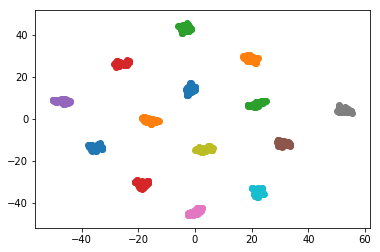

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

color = 0
for i in range(len((X_embedded))):
  el = X_embedded[i]
  if i % 51 == 0 and not i==0:
    color+=1
    color=color%10
  plt.scatter(el[0], el[1], color="C" + str(color))

In [60]:
print ("Distance between two different faces in Train Set")

file1 = ('faceid_train/(2012-05-16)(154211)/015_1_c.bmp')
inp1 = create_input_rgb(file1)
file1 = ('faceid_train/(2012-05-16)(153054)/004_1_c.bmp')
inp2 = create_input_rgb(file1)

model_final.predict([inp1, inp2])


Distance between two different faces in Train Set


array([[0.7088729]], dtype=float32)

In [63]:
print ("Distance between two same faces in Validation Set")

file1 = ('faceid_val/(2012-05-18)(152717)/015_1_c.bmp')
inp1 = create_input_rgb(file1)
file1 = ('faceid_val/(2012-05-18)(152717)/004_1_c.bmp')
inp2 = create_input_rgb(file1)

model_final.predict([inp1, inp2])


Distance between two same faces in Validation Set


array([[0.05561978]], dtype=float32)

In [62]:
print ("Distance between two different faces in Validation Set")

file1 = ('faceid_val/(2012-05-18)(152717)/015_1_c.bmp')
inp1 = create_input_rgb(file1)
file1 = ('faceid_val/(2012-05-18)(153532)/004_1_c.bmp')
inp2 = create_input_rgb(file1)

model_final.predict([inp1, inp2])


Distance between two different faces in Validation Set


array([[1.0902051]], dtype=float32)

#### We can see the distance between similar faces is small and high for the different faces

Retraining a network to perform classification, even fine-tuning one, is a complex thing to do especially on a mobile device. One has to provide the network with both positive examples (a small amount: the registration pictures) and negative examples (ideally, the huge dataset that Apple should have gathered) that is unfeasible on a mobile device.

Recent work on Face Recognition using these techniques achieve incredible results (check out FaceNet), while being able to become a one-shot learning system (train once and for all).